This notebook sets up forcing for two storm surge simulations: one during a neap tide and one during a spring tide. The idea is to examine the influence of the tidal dissipation on surge amplitude. The surge from Feb 1-8, 2006 will be used in both simulations. However, I will run over different times in order to capture the spring/neap variability.



Steps:
1. Look up spring/neap cycle in dec 2006
2. Split feb2006 forcing into days (Feb 1-8)
3. Copy into time periods of for spring and neap. 

Ideally each simulation is 7 days long.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from dateutil import tz
import os
import glob

from salishsea_tools.nowcast import figures
from salishsea_tools import nc_tools


%matplotlib inline

# Spring/Neap

In [2]:
def dateParserMeasured2(s):
    """
    converts string in %d-%b-%Y %H:%M:%S format Pacific time to a datetime object UTC time.
    """
    PST=tz.tzoffset("PST",-28800)
    #convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%d-%b-%Y %H:%M:%S ")
    #add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST)
    #convert to UTC
    return aware.astimezone(tz.tzutc())

In [3]:
fname = '/data/nsoontie/MEOPAR/storm-surge/Revisions/tides/analysis/PointAtkinson_t_tide_compare8_31-Dec-2005_02-Jan-2007_snr2_filter.csv'

ttide = pd.read_csv(fname,skiprows=3,parse_dates=[0],date_parser=dateParserMeasured2)
ttide = ttide.rename(columns={'Time_Local ': 'time', ' pred_8 ': 'pred_8', ' pred_all ': 'pred_all'})


(732646.0, 732676.0)

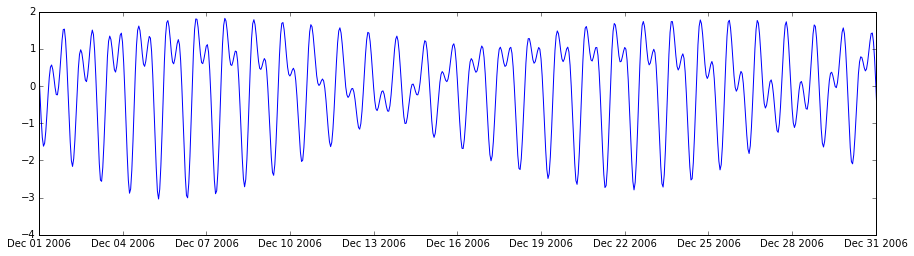

In [4]:
to=datetime.datetime(2006,12,1)
tf=datetime.datetime(2006,12,31)

fig,ax=plt.subplots(1,1,figsize=(15,4))
plt.plot(ttide.time, ttide.pred_all)

ax.set_xlim([to,tf])

**Spring surge**
* December 1-7, 2006

**Neap surge**
* December 12-18, 2006


# Divide forcing

First, load the feb 2006 forcing file.

In [5]:
fname = '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/ssh_y2006m02.nc'
res = nc.Dataset(fname)

nc_tools.show_variables(res)

[u'time_counter', u'nav_lat', u'nav_lon', u'sossheig', u'vobtcrtx', u'vobtcrty', u'nbidta', u'nbjdta', u'nbrdta']


In [6]:
ssh = res.variables['sossheig']
time =res.variables['time_counter']


#fboundary parameters
startj = 384
endj = 471
lengthj = endj-startj
r = 1

#load bathy
fB = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
lat = fB.variables['nav_lat'][:]
lon = fB.variables['nav_lon'][:]
fB.close()

In [7]:
def prepare_netcdf(ssh_file, count, ssh):
    # dataset attributes
    nc_tools.init_dataset_attrs(
    ssh_file, 
    title='Juan de Fuca SSH hourly values', 
    notebook_name='', 
    nc_filepath='/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring' + filename,
    comment='SSH for Tofino - testing spring/neap effect')

    
    #dimensions
    ssh_file.createDimension('xbT', lengthj*r)
    ssh_file.createDimension('yb', 1)
    ssh_file.createDimension('time_counter', None)
    # variables
    # time_counter
    time_counter = ssh_file.createVariable('time_counter', 'float32', ('time_counter'))
    time_counter.long_name = 'Time axis'
    time_counter.axis = 'T'
    time_counter.units = 'hour since 00:00:00 '
    # nav_lat and nav_lon
    nav_lat = ssh_file.createVariable('nav_lat','float32',('yb','xbT'))
    nav_lat.long_name = 'Latitude'
    nav_lat.units = 'degrees_north'
    nav_lon = ssh_file.createVariable('nav_lon','float32',('yb','xbT'))
    nav_lon.long_name = 'Longitude'
    nav_lon.units = 'degrees_east'
    # ssh
    sossheig = ssh_file.createVariable('sossheig', 'float32', 
                               ('time_counter','yb','xbT'), zlib=True)
    sossheig.units = 'm'
    sossheig.long_name = 'Sea surface height'   
    sossheig.coordinates = 'nav_lon nav_lat time_counter'
    sossheig.grid = 'SalishSea2'
    # vobtcrtx, vobtcrty
    vobtcrtx = ssh_file.createVariable('vobtcrtx', 'float32',
                                   ('time_counter','yb','xbT'), zlib=True)
    vobtcrtx.units = 'm/s'
    vobtcrtx.long_name = 'Barotropic U Velocity- ZEROD'   
    vobtcrtx.grid = 'SalishSea2'
    vobtcrty = ssh_file.createVariable('vobtcrty', 'float32',
                                   ('time_counter','yb','xbT'), zlib=True)
    vobtcrty.units = 'm/s'
    vobtcrty.long_name = 'Barotropic V Velocity- ZEROD'   
    vobtcrty.grid = 'SalishSea2'
    # nbidta, ndjdta, ndrdta
    nbidta = ssh_file.createVariable('nbidta', 'int32' , ('yb','xbT'), zlib=True)
    nbidta.long_name = 'i grid position'
    nbidta.units = 1
    nbjdta = ssh_file.createVariable('nbjdta', 'int32' , ('yb','xbT'), zlib=True)
    nbjdta.long_name = 'j grid position'
    nbjdta.units = 1
    nbrdta = ssh_file.createVariable('nbrdta', 'int32' , ('yb','xbT'), zlib=True)
    nbrdta.long_name = 'position from boundary'
    nbrdta.units = 1
    
    for ir in range(0,r):
        nav_lat[0,ir*lengthj:(ir+1)*lengthj] = lat[startj:endj,ir]
        nav_lon[0,ir*lengthj:(ir+1)*lengthj] = lon[startj:endj,ir]
        nbidta[0,ir*lengthj:(ir+1)*lengthj] = ir
        nbjdta[0,ir*lengthj:(ir+1)*lengthj] = range(startj,endj)
        nbrdta[0,ir*lengthj:(ir+1)*lengthj] = ir
        
    for ib in range(0,lengthj*r):
        sossheig[0:count,0,ib] = ssh[0:count]
        time_counter[0:count] = range(1,count+1)
        vobtcrtx[0:count,0,ib] = 0*np.ones(count)
        vobtcrty[0:count,0,ib] = 0*np.ones(count)

Loop through Feb 1-10. Create the spring files Dec 1-10, 2006.

In [8]:
start_day = datetime.datetime(2006,12,1)
for d in np.arange(1,11):
    day = start_day + datetime.timedelta(days = d-1)
    
    #grab subset of ssh data 
    ssh_sub = ssh[24*(d-1):24*d,:,:]
    print ssh_sub
    
    #print day and time counters for sanity check
    print day
    print time[24*(d-1):24*d]
    
    # construct file name
    filename = day.strftime('ssh_y%Ym%md%d.nc')
    ssh_file = nc.Dataset(filename, 'w', zlib=True)
    print filename
    #construct netcdf
    prepare_netcdf(ssh_file,24,ssh_sub)
    
    ssh_file.close()

[[[ 0.67745298  0.67745298  0.67745298 ...,  0.67745298  0.67745298
    0.67745298]]

 [[ 0.81208497  0.81208497  0.81208497 ...,  0.81208497  0.81208497
    0.81208497]]

 [[ 0.86075902  0.86075902  0.86075902 ...,  0.86075902  0.86075902
    0.86075902]]

 ..., 
 [[ 0.27557901  0.27557901  0.27557901 ...,  0.27557901  0.27557901
    0.27557901]]

 [[ 0.33987099  0.33987099  0.33987099 ...,  0.33987099  0.33987099
    0.33987099]]

 [[ 0.37389499  0.37389499  0.37389499 ...,  0.37389499  0.37389499
    0.37389499]]]
2006-12-01 00:00:00
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.]
ssh_y2006m12d01.nc
file format: NETCDF4
Conventions: CF-1.6
title: Juan de Fuca SSH hourly values
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: REQUIRED
references: REQUIRED
history: [2015-05-20 11:11:02] Created netCDF4 zlib=True dataset.
comment: SSH for Tofino - testing spring/ne

Copy these files into forcing directory

In [9]:
srcdir='.'
dstdir='/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/'

import shutil

for basename in os.listdir(srcdir):
    if basename.endswith('.nc'):
        pathname = os.path.join(srcdir, basename)
        if os.path.isfile(pathname):
            shutil.copy2(pathname, dstdir)

Copy files into neap period Dec 11-21, 2011

In [33]:
spring=datetime.datetime(2006,12,1)
neap = datetime.datetime(2006,12,11)
for d in np.arange(1,11):
    ds = spring +datetime.timedelta(days=d-1)
    dn= neap +datetime.timedelta(days=d-1)
    print ds,dn
    old = ds.strftime('ssh_y%Ym%md%d.nc')
    new = dn.strftime('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y%Ym%md%d.nc')
    print old, new
    shutil.copy2(old,new)

2006-12-03 00:00:00 2006-12-11 00:00:00
ssh_y2006m12d03.nc /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d11.nc
2006-12-04 00:00:00 2006-12-12 00:00:00
ssh_y2006m12d04.nc /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d12.nc
2006-12-05 00:00:00 2006-12-13 00:00:00
ssh_y2006m12d05.nc /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d13.nc
2006-12-06 00:00:00 2006-12-14 00:00:00
ssh_y2006m12d06.nc /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d14.nc
2006-12-07 00:00:00 2006-12-15 00:00:00
ssh_y2006m12d07.nc /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d15.nc
2006-12-08 00:00:00 2006-12-16 00:00:00
ssh_y2006m12d08.nc /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d16.nc
2006-12-09 00:00:00 2006-12-17 00:00:00
ssh_y2006m12d09.nc /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d17.nc

# Check

In [35]:
springs = glob.glob('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/*.nc')
springs.sort(key=os.path.basename)
print springs

['/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d03.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d04.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d05.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d06.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d07.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d08.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d09.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d10.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d11.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d12.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/spring/ssh_y2006m12d7.nc']


In [36]:
neaps = glob.glob('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/*.nc')
neaps.sort(key=os.path.basename)
print neaps

['/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d11.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d12.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d13.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d14.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d15.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d16.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d17.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d18.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d19.nc', '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/ssh/neap/ssh_y2006m12d20.nc']


In [49]:
s_ssh=np.array([])
n_ssh =np.array([])

for s,n in zip(springs,neaps):
    fs=nc.Dataset(s)
    s1=fs.variables['sossheig'][:,0,1]
    s_ssh=np.append(s_ssh,s1)
    
    fn=nc.Dataset(n)
    n1=fn.variables['sossheig'][:,0,1]
    n_ssh=np.append(n_ssh,n1)


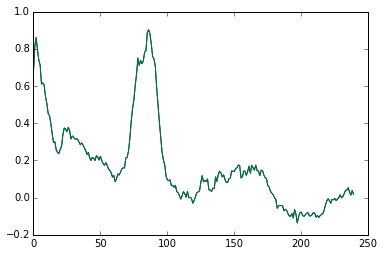

In [51]:
fig,ax=plt.subplots(1,1)

ax.plot(s_ssh)
ax.plot(n_ssh)

Looks like a match.

* I will neglect Port Hardy forcing because it isn't a very strong component. 
* I will also neglect wind forcing/river. I'm only interested in surge propogation modulated but the tides.